In [111]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
df = pd.read_parquet('../data/world_bank_variables_target.pq')

In [153]:
df.head()

,Country_Name,Country_Code,Year,Cereal_Yield,Arable_Land_Percent,Value_Added_AFF,Arable_Land_Person,Freshwater_Withdrawl,Fertilizer,Education_Expenditure,Natural_Resource_Rents
0,Norway,NOR,1971.0,8.079401,1.163547,1.804178,0.187304,1.429050,5.563376,1.796640,0.334428
1,Netherlands,NLD,1971.0,8.371358,3.170024,1.758224,0.056718,1.019467,6.661533,1.991730,0.093283
2,Nicaragua,NIC,1971.0,6.988136,2.266147,3.306797,0.344867,1.213858,3.261124,1.250483,1.206264
3,Namibia,NAM,1971.0,5.842094,0.583301,3.138460,0.609293,1.185488,1.919471,1.506671,2.041281
4,Niger,NER,1971.0,6.053970,2.288729,4.196612,1.206025,0.253070,0.022200,0.718947,1.028939


## Create test train

In [100]:
X = df[['Year', 'Fertilizer', 'Value_Added_AFF']]
y = df['Cereal_Yield']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 56)

In [102]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7280, 3) (1820, 3) (7280,) (1820,)


## First check polynomial features with linear regression model

In [115]:
scores = []

for degree in np.arange(1, 10):
    pipe = Pipeline([('polynomial', PolynomialFeatures(degree = degree)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    mae_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mae_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    scores.append([degree, mae_train, mae_test])

In [116]:
poly_line_reg_scores = pd.DataFrame(scores, columns = ['Degree', 'MAPE Train', 'MAPE Test'])

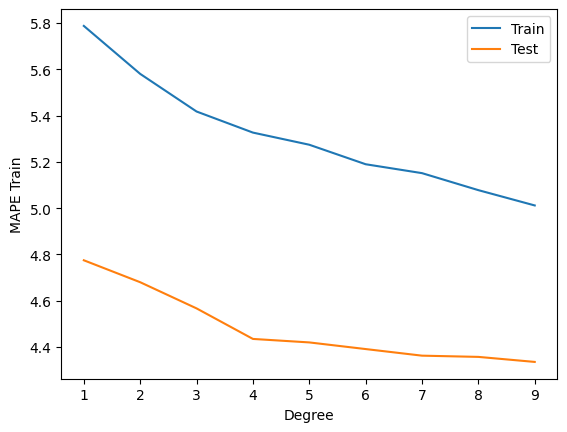

In [117]:
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Train', label = 'Train')
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Test', label = 'Test');

In [121]:
pipe = Pipeline([('polynomial', PolynomialFeatures(degree = 2)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
pipe.fit(X_train, y_train)

y_pred_test = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

mae_test = mean_absolute_percentage_error(y_test, y_pred_test)
mae_train = mean_absolute_percentage_error(y_train, y_pred_train)
print('mape_test:', round(mae_test, 2), '\nmape_train:', round(mae_train, 2))

mape_test: 0.05 
mape_train: 0.06


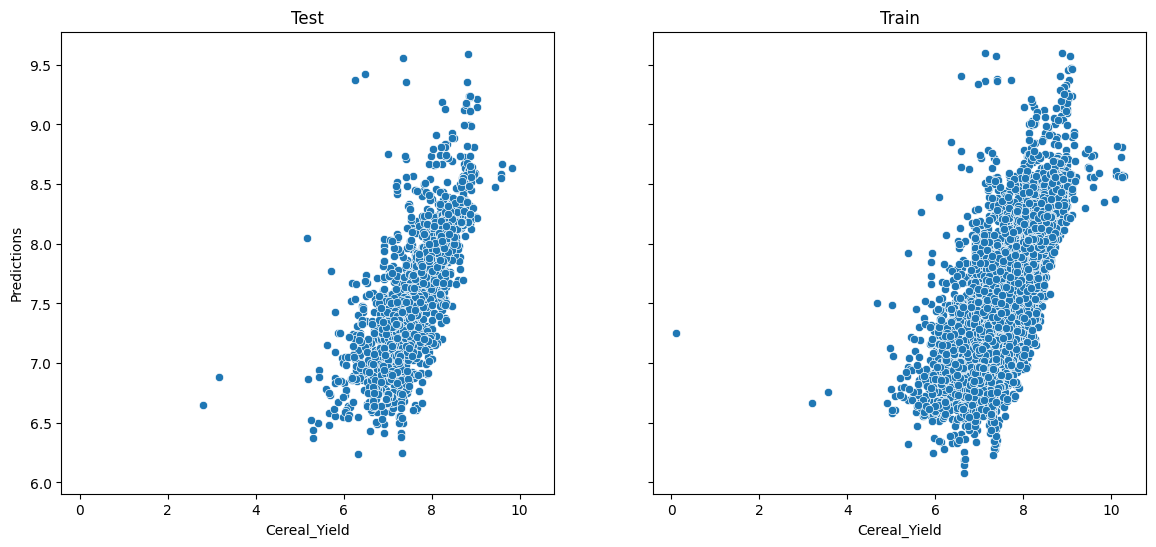

In [122]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6), sharex = True, sharey = True)
sns.scatterplot(x = y_test, y = y_pred_test, ax = ax[0])
ax[0].set_ylabel("Predictions")
ax[0].set_title("Test")

sns.scatterplot(x = y_train, y = y_pred_train, ax = ax[1])
ax[1].set_title("Train");

In [123]:
pd.DataFrame({'Features': pipe['polynomial'].get_feature_names_out(X_train.columns), 'coefs': pipe['lin_reg'].coef_}).sort_values(by = 'coefs')

,Features,coefs
3,Value_Added_AFF,-5.484785
1,Year,-4.317022
2,Fertilizer,-2.783812
8,Fertilizer Value_Added_AFF,-0.362217
0,1,0.000000
9,Value_Added_AFF^2,0.026299
7,Fertilizer^2,0.035801
5,Year Fertilizer,3.618663
4,Year^2,4.229477
6,Year Value_Added_AFF,5.680929


## Now try regularisation

In [124]:
ridge_reg = Pipeline(steps = [
    ('polynomial', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge_reg', Ridge())
])
ridge_reg_param = {
    "ridge_reg__alpha": np.logspace(-3, 1, 10),
    "polynomial__degree": [2]
}

gs_ridge_reg = GridSearchCV(ridge_reg,
                        ridge_reg_param,
                        cv = 5,
                        scoring = 'neg_mean_absolute_percentage_error',
                        verbose = 1,
                        n_jobs = -1,
                        error_score = 0.0)

In [125]:
lasso_reg = Pipeline(steps = [
    ('polynomial', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lasso_reg', Lasso(max_iter = 2000))
])
lasso_reg_param = {
    "lasso_reg__alpha": np.logspace(-3, -1, 10),
    "polynomial__degree": [2]
}

gs_lasso_reg = GridSearchCV(lasso_reg,
                        lasso_reg_param,
                        cv = 5,
                        scoring = 'neg_mean_absolute_percentage_error',
                        verbose = 1,
                        n_jobs = -1,
                        error_score = 0.0)

In [126]:
grids = {'gs_ridge_reg': gs_ridge_reg, 'gs_lasso_reg': gs_lasso_reg}

In [127]:
grid_searches_outputs = []

for name, grid_search in grids.items():
    print("-"*100)
    print(name, '\n')
    # fit the pipeline + gridsearch
    grid_search.fit(X_train, y_train)
    #report 
    print('best_estimator_:', grid_search.best_estimator_)
    print('best_score_:', grid_search.best_score_)
    print('best_params_:', grid_search.best_params_)
    # test
    predictions = grid_search.best_estimator_.predict(X_test)
    mae = mean_absolute_percentage_error(y_test, predictions)
    print(mae)
    # add all into list
    grid_searches_outputs.append([grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, mae])

----------------------------------------------------------------------------------------------------
gs_ridge_reg 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best_estimator_: Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('ridge_reg', Ridge(alpha=0.021544346900318832))])
best_score_: -0.05587576052006902
best_params_: {'polynomial__degree': 2, 'ridge_reg__alpha': 0.021544346900318832}
0.046736376044555494
----------------------------------------------------------------------------------------------------
gs_lasso_reg 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/sean/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.080e-01, tolerance: 2.991e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/sean/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e-01, tolerance: 3.000e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


best_estimator_: Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('lasso_reg', Lasso(alpha=0.001, max_iter=2000))])
best_score_: -0.055942808465437366
best_params_: {'lasso_reg__alpha': 0.001, 'polynomial__degree': 2}
0.046613727878513395


In [129]:
grid_searches_outputs_df = (pd.DataFrame(grid_searches_outputs, 
                                         columns = ['best_estimator', 'best_params', 'train_mape', 'test_mape'])
                            .sort_values(by = 'test_mape'))

In [130]:
grid_searches_outputs_df

,best_estimator,best_params,train_mape,test_mape
1,"(PolynomialFeatures(), StandardScaler(), Lasso...","{'lasso_reg__alpha': 0.001, 'polynomial__degre...",-0.055943,0.046614
0,"(PolynomialFeatures(), StandardScaler(), Ridge...","{'polynomial__degree': 2, 'ridge_reg__alpha': ...",-0.055876,0.046736


In [131]:
y_pred = grid_searches_outputs_df.iloc[0,0].predict(X_test)

In [132]:
all_data = grid_searches_outputs_df.iloc[0,0].fit(X, y)

/home/sean/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.664e-01, tolerance: 4.626e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [133]:
y_pred_all_data = all_data.predict(X)

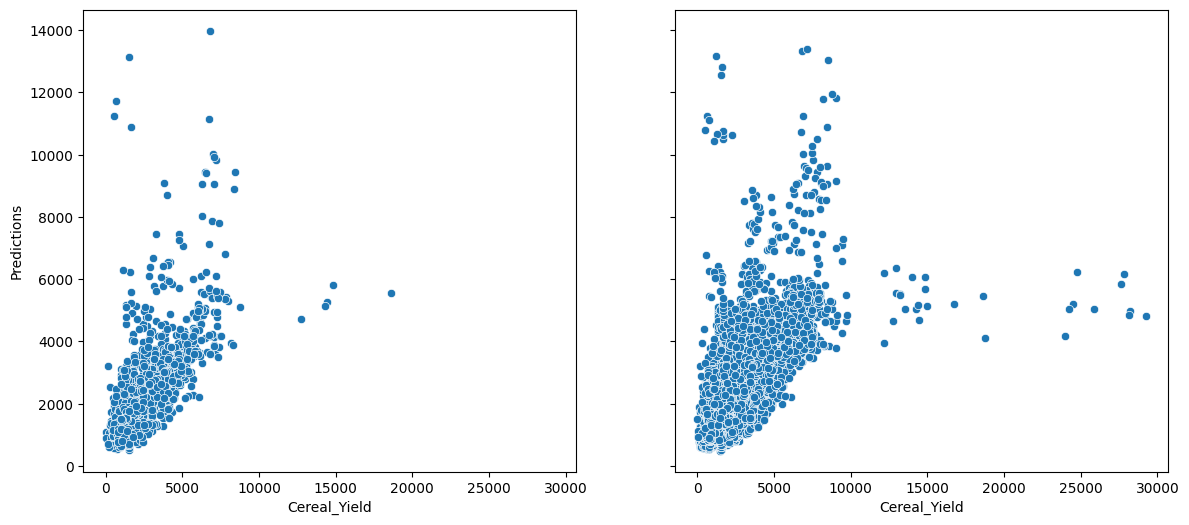

In [135]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6), sharex = True, sharey = True)
sns.scatterplot(x = np.exp(y_test), y = np.exp(y_pred), ax = ax[0])
ax[0].set_ylabel("Predictions")

sns.scatterplot(x = np.exp(y), y = np.exp(y_pred_all_data), ax = ax[1]);

## Now we will add in the other variables

In [172]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [207]:
def linear_reg_poly(poly_max: int, random_state = 56):
    
    X = df.drop(columns = ['Cereal_Yield', 'Country_Name' ,'Country_Code'])
    y = df['Cereal_Yield']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
    
    outputs = pd.DataFrame(columns = ['Degree', 'k', 'MAPE Train', 'MAPE Test'])
    
    for k in np.arange(1, 9):
        selectkbest = SelectKBest(f_regression, k = k)
        selectkbest.fit(X, y)
        
        X_train_ = selectkbest.transform(X_train)
        X_test_ = selectkbest.transform(X_test)
    
        scores = []
        for degree in np.arange(1, poly_max):
            pipe = Pipeline([('polynomial', PolynomialFeatures(degree = degree)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
            pipe.fit(X_train_, y_train)
            y_pred_test = pipe.predict(X_test_)
            y_pred_train = pipe.predict(X_train_)
            mae_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
            mae_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
            
            scores.append([degree, k, mae_train, mae_test])
          
            poly_line_reg_scores = pd.DataFrame(scores, columns = ['Degree', 'k', 'MAPE Train', 'MAPE Test'])
            
        outputs = pd.concat([outputs, poly_line_reg_scores], axis = 0)
        
    return outputs
    

In [212]:
outputs = linear_reg_poly(6, random_state = 10)

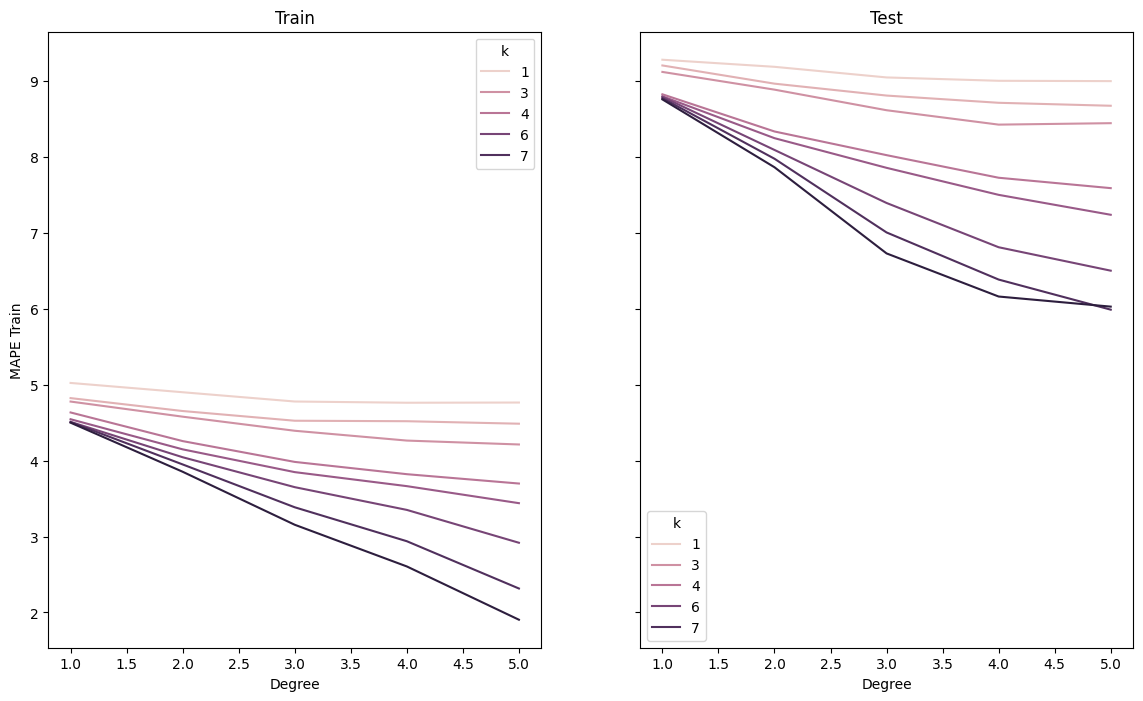

In [214]:
fig, ax = plt.subplots(1, 2, figsize = (14, 8), sharey = True)

sns.lineplot(data = outputs, x = 'Degree', y = 'MAPE Train', hue = 'k', ax = ax[0])
ax[0].set_title("Train")

sns.lineplot(data = outputs, x = 'Degree', y = 'MAPE Test', hue = 'k', ax = ax[1])
ax[1].set_title("Test");

### Export Model

In [28]:
import pickle

In [29]:
with open('../data/first_model_lin_regression.pickle', 'wb') as f:
    pickle.dump(grid_searches_outputs_df.iloc[0,0], f)

In [30]:
X_test.to_parquet('../data/X_test.pq')